In [1]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
import logging


def allow_soft_placement():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if  len(physical_devices) == 0:
        logging.warning("Not enough GPU hardware devices available")
    else:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

allow_soft_placement()

import os
os.chdir('../src/models/')

import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from hyperopt import space_eval
sys.path.append(os.path.abspath("../.."))
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)
# import pandas as pd

import random
import matplotlib.pyplot as plt
from src.code_snippets.utils.data_handler import read_pickle,save_to_pickle
from src.code_snippets.models.many_to_one_lstm_cnn import LstmCnn
from src.code_snippets.models.hyperparameter_tuning import safeHyperopt,extract_trial_results
import seaborn as sns


In [2]:
seed = 100
random.seed(seed)
np.random.seed(seed)

In [3]:
train_data = read_pickle('../../data/processed/processed_data_train.pickle')
val_data = read_pickle('../../data/processed/processed_data_val.pickle')
#test_data = read_pickle('../data/processed/processed_data_test.pickle')


In [4]:
num_observations = len(train_data['X_aux'])
idx = np.arange(num_observations)

sample_portion = 0.1
sample_size = int(num_observations*sample_portion)
print(sample_size)

12292


In [5]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
assert num_gpus_available == 1, 'GPU IS NOT AVAILABLE' 
print("Num GPUs Available: ",num_gpus_available )

Num GPUs Available:  1


In [6]:
np.random.seed(seed)
sampled_idx = np.random.choice(idx,sample_size,replace = False)

use_sample = False

if use_sample:
    train_data['X_indices'] = train_data['X_indices'][sampled_idx]
    train_data['X_aux'] = train_data['X_aux'][sampled_idx]
    train_data['y'] = train_data['y'][sampled_idx]
else:
    train_data['X_indices'] = train_data['X_indices']
    train_data['X_aux'] = train_data['X_aux']
    train_data['y'] = train_data['y']

In [7]:
trainer = LstmCnn(train_data,
                            val_data,
                            "../../data/raw/pretrained_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt")


In [ ]:
from hyperopt import hp, space_eval

space = {   'n_units': 256,
            'add_recurrent_layer': True,
            'dropout': hp.choice('dropout', np.arange(.4,0.6,0.1)),
            'spatial_dropout':hp.choice('spatial_dropout',np.arange(.4,.6,.1)),
            'hidden_dense_units': 128,
            'batch_size' :2**5,
            'epochs' : 1,
            'learning_rate':10**hp.uniform('learning_rate',-3,-2.559),
            'bidirectional':True
        }



In [ ]:
trainer.search_hyperparameters(space = space,
                               version = 4,
                               total_trials = 30)

In [ ]:
trials = read_pickle('../../models/many_to_one_LSTM/V2/trials.pickle')
space = read_pickle('../../models/many_to_one_LSTM/V2/space_hyperopt.pickle')

In [ ]:
best_params = space_eval(space,trials.argmin) 
print(trials.best_trial['result']['loss'])
best_params


In [ ]:
plot_metrics(trials.best_trial['result']['model_history'],ylim=(0,0.35))

In [ ]:
results = list(map(extract_trial_results,trials.trials))

In [ ]:
results = pd.DataFrame(results)
results.drop('epochs',axis=1,inplace=True)
results.sort_values(by='f1_val',inplace=True,ascending=False)

In [ ]:
plt.figure(figsize=(13,10))
sns.heatmap(results.corr(),cmap='coolwarm',annot=True)
plt.show()

In [ ]:
sns.boxenplot(x='batch_size',y='f1_val',data=results)


# =======================================================================================

# Playground

In [ ]:
def get_layer_output(model,layer,input_):
    get_layer_output = K.function([model.layers[0].input],
                      [model.layers[layer].output])

    layer_output = get_layer_output(input_)
    return layer_output[0]

In [8]:
trainer.set_model(n_units=256,
             n_filters = 128,
             dropout=0.4,
             spatial_dropout=0.4,
             hidden_dense_units=0,
             learning_rate=0.0017436142055397088,
             global_avg_pool=True,
             global_max_pool=True
    )



Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [20]:
trainer.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 115)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 115, 200)     238703000   input_7[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 115, 200)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 115, 512)     935936      spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

In [8]:
#Input layer
from tensorflow.keras.layers import (MaxPool1D,GlobalAveragePooling1D, GlobalMaxPooling1D,
                                     Input,LSTM,Conv1D,
                                     Dropout, Dense, BatchNormalization, 
                                     Activation, Bidirectional,SpatialDropout1D,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from src.code_snippets.dataprep.embeddings_preprocessing.data_preparation import pretrained_embedding_layer
from src.code_snippets.evaluation.model_evaluation import f1_metric, plot_metrics

global_max_pool = True
global_avg_pool = False
n_units=256
dropout=0.4
spatial_dropout=0.4
hidden_dense_units=128
learning_rate=0.0017436142055397088
filter_size = 2
n_filters=128
padding='valid'
stride = 1

sentence_indices = Input((115),dtype='int32')

# Embedding Layer
embedding_layer = pretrained_embedding_layer(trainer.gensim_model,
                                             trainer.word_to_index)

# Propagate sentence_indices through your embedding layer
embeddings = embedding_layer(sentence_indices)   
embeddings = SpatialDropout1D(spatial_dropout,seed= seed)(embeddings)

#LSTM 1
X = Bidirectional(LSTM(n_units,return_sequences=True))(embeddings)

items_to_concat = []

#1D Convolution

X = Conv1D(filters = n_filters, kernel_size = filter_size,strides = stride,padding = padding)(X)
#X = BatchNormalization()(X)
X = Activation(activation='relu')(X)

X = MaxPool1D()(X)

X = Conv1D(filters = n_filters*2, kernel_size = filter_size,strides = stride,padding = padding)(X)
#X = BatchNormalization()(X)
X = Activation(activation='relu')(X)

#TODO: ADD BATCH NORM ??
if global_avg_pool:
    avg_pool = GlobalAveragePooling1D()(X)
    items_to_concat.append(avg_pool)

if global_max_pool:
    max_pool = GlobalMaxPooling1D()(X)
    items_to_concat.append(max_pool)

if len(items_to_concat) == 1:
    X = items_to_concat[0]
else:
    X = concatenate(items_to_concat)

if hidden_dense_units>0:
    #Hiden Dense Layer 1
    X = Dense(hidden_dense_units)(X)
    X = BatchNormalization()(X) 
    X = Activation(activation='relu')(X)
    X = Dropout(dropout,seed = seed)(X)

#Output layer
X = Dense(1,activation='sigmoid')(X)

trainer.model = Model(sentence_indices,X)

opt = Adam(learning_rate=learning_rate)
trainer.model.compile(loss='binary_crossentropy',metrics = [f1_metric],optimizer=opt)



Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [32]:
#Input layer
from tensorflow.keras.layers import (MaxPool1D,GlobalAveragePooling1D, GlobalMaxPooling1D,
                                     Input,LSTM,Conv1D, Conv2D,MaxPool2D,
                                     Dropout, Dense, BatchNormalization, 
                                     Activation, Bidirectional,SpatialDropout1D,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from src.code_snippets.dataprep.embeddings_preprocessing.data_preparation import pretrained_embedding_layer
from src.code_snippets.evaluation.model_evaluation import f1_metric, plot_metrics


hidden_dense_units = 256
dropout = 0.4
spatial_dropout = 0.4
learning_rate=0.0017436142055397088
n_units = 128

sentence_indices = Input((115),dtype='int32')

# Embedding Layer
embedding_layer = pretrained_embedding_layer(trainer.gensim_model,
                                             trainer.word_to_index)

# Propagate sentence_indices through your embedding layer
embeddings = embedding_layer(sentence_indices)   
embeddings = SpatialDropout1D(spatial_dropout,seed= seed)(embeddings)

X = Bidirectional(LSTM(n_units,return_sequences=True))(embeddings)

X = tf.expand_dims(X,axis=-1)
X = Conv2D(filters = 100, kernel_size = 5,padding = 'valid', activation = 'relu')(X)
X = MaxPool2D(pool_size=(5, 5))(X)
X = Conv2D(filters = 100, kernel_size = 5,padding = 'valid', activation = 'relu')(X)
X = MaxPool2D(pool_size=(5, 5))(X)

#X = Dense(hidden_dense_units)(X)
#X = BatchNormalization()(X) 
#X = Activation(activation='relu')(X)
#X = Dropout(dropout,seed = seed)(X)

X = BatchNormalization()(X) 
X = Activation(activation='relu')(X)
X = Dropout(dropout,seed = seed)(X)
#Output layer
X = tf.keras.layers.Flatten()(X)
X = Dense(1,activation='sigmoid')(X)

trainer.model = Model(sentence_indices,X)

opt = Adam(learning_rate=learning_rate)
trainer.model.compile(loss='binary_crossentropy',metrics = [f1_metric],optimizer=opt)



Executing op __inference_keras_scratch_graph_158726 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [33]:
trainer.model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 115)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 115, 200)          238703000 
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 115, 200)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 115, 256)          336896    
_________________________________________________________________
tf_op_layer_ExpandDims_5 (Te [(None, 115, 256, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 111, 252, 100)     2600      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 50, 100)       0   

In [ ]:
trainer.fit_model(epochs=100,batch_size = 64)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet

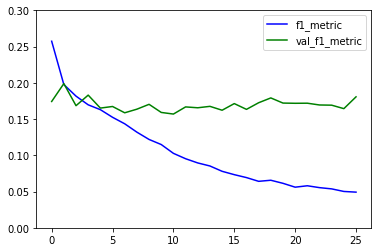

In [11]:
plot_metrics(trainer.model.history,ylim=(0,0.3))

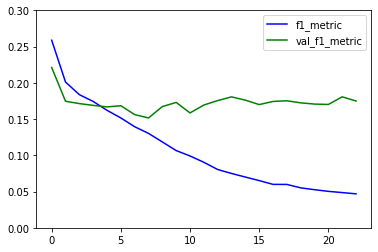

In [15]:
plot_metrics(trainer.model.history,ylim=(0,0.3))

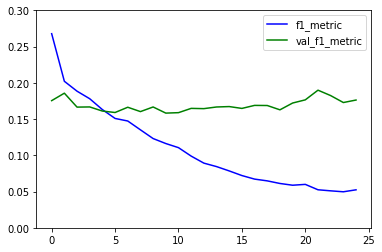

In [17]:
A = plot_metrics(trainer.model.history,ylim=(0,0.3))

In [45]:
model = tf.keras.models.load_model('../../models/many_to_one_LSTM/model.h5',custom_objects={'f1_metric':f1_metric})

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:lo

In [46]:
trainer.model = model

In [47]:
trainer.generate_metrics(trainer.val_data['X_indices'],y_test = trainer.val_data['y'])

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_143037 in device /job:localhost/replica:0/task:0/device:GPU:0


0.8555478

In [8]:
#Input layer
from tensorflow.keras.layers import (Attention,MaxPool1D,GlobalAveragePooling1D, GlobalMaxPooling1D,
                                     Input,LSTM,Conv1D, Conv2D,MaxPool2D,
                                     Dropout, Dense, BatchNormalization, 
                                     Activation, Bidirectional,SpatialDropout1D,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from src.code_snippets.dataprep.embeddings_preprocessing.data_preparation import pretrained_embedding_layer
from src.code_snippets.evaluation.model_evaluation import f1_metric, plot_metrics


hidden_dense_units = 128
dropout = 0.5
spatial_dropout = 0.4
learning_rate=0.0017436142055397088
n_units = 256

sentence_indices = Input((115),dtype='int32')

# Embedding Layer
embedding_layer = pretrained_embedding_layer(trainer.gensim_model,
                                             trainer.word_to_index)

# Propagate sentence_indices through your embedding layer
embeddings = embedding_layer(sentence_indices)   
embeddings = SpatialDropout1D(spatial_dropout,seed= seed)(embeddings)

lstm_output = Bidirectional(LSTM(n_units,return_sequences=True))(embeddings)
lstm_output = Bidirectional(LSTM(n_units,return_sequences=True))(lstm_output)

e = Dense(128,activation = 'tanh')(lstm_output)
energies = Dense(1,activation = 'relu')(e)
alphas = Activation('softmax')(energies)
X = tf.keras.layers.Dot(axes=1)([alphas,lstm_output])


X = Dense(hidden_dense_units)(X)
X = BatchNormalization()(X) 
X = Activation(activation='relu')(X)
X = Dropout(dropout,seed = seed)(X)

X = Dense(1,activation='sigmoid')(X)

trainer.model = Model(sentence_indices,X)

opt = Adam(learning_rate=learning_rate)
trainer.model.compile(loss='binary_crossentropy',metrics = [f1_metric],optimizer=opt)



Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [9]:
trainer.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 115)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 115, 200)     238703000   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 115, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 115, 512)     935936      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [10]:
trainer.fit_model(epochs=100,batch_size = 128)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet

Epoch 6/100
122920/122920 [==============================] - 112s 913us/sample - loss: 0.0823 - f1_metric: 0.8451 - val_loss: 0.0902 - val_f1_metric: 0.8317
Epoch 7/100
122920/122920 [==============================] - 112s 909us/sample - loss: 0.0773 - f1_metric: 0.8529 - val_loss: 0.0875 - val_f1_metric: 0.8437
Epoch 8/100
122920/122920 [==============================] - 111s 902us/sample - loss: 0.0708 - f1_metric: 0.8676 - val_loss: 0.0958 - val_f1_metric: 0.8496
Epoch 9/100
122920/122920 [==============================] - 110s 898us/sample - loss: 0.0656 - f1_metric: 0.8779 - val_loss: 0.0945 - val_f1_metric: 0.8503
Epoch 10/100
122920/122920 [==============================] - 109s 889us/sample - loss: 0.0596 - f1_metric: 0.8906 - val_loss: 0.0942 - val_f1_metric: 0.8346
Epoch 11/100
122920/122920 [==============================] - 109s 890us/sample - loss: 0.0563 - f1_metric: 0.8949 - val_loss: 0.1049 - val_f1_metric: 0.8309
Epoch 12/100
122920/122920 [============================

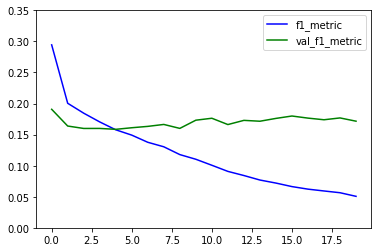

In [12]:
plot_metrics(trainer.model.history,ylim=(0,0.35))

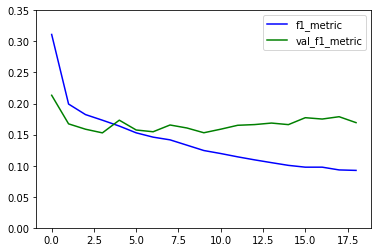

In [16]:
plot_metrics(trainer.model.history,ylim=(0,0.35))